In [2]:
## This script evaluates the correlations between models and all experimental datasets for plotting figures
# Requires that sentence pairwise similarities have already been computed using 'Cals_sent_sim_[type].ipynb' files.
# Run using base python 3.9
# James Fodor 2023

# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sentence_embeds_processing as sep
import os
import re

from scipy.stats import spearmanr

# base path for all data files
path_root = "D:\Study and Projects\School Work\Year 25 - PhD 1\Data\\"
data_pairs_path = path_root+'\\Sentence Similarity Data\\Sentence Similarities Final\\'
data_nonpaired_path = path_root+'\\Neuroimaging Data\\'
sims_path = 'Analysis Results\Sentence Similarities\\'
parses_path = 'Analysis Results\Sentence Parses\\'

# set display options
np.set_printoptions(precision=4, threshold=5000, linewidth=220, suppress=True, floatmode='fixed')
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set()

{0: 'GS2011_processed', 1: 'KS2013_processed', 2: 'Fodor_pilot_2022', 3: 'STS131_processed', 4: 'SICK_relatedness', 5: 'STSb_captions_test', 6: 'STSb_forums_test', 7: 'STSb_headlines_test', 8: 'STSb_test', 9: 'STS3k_all'}


### Load sentence similarity datasets

In [ ]:
# Show available datasets
pairs = True # specify if we are using paired data or list of sentences
if pairs==True:
    datasets = sep.available_pair_datasets
else:
    datasets = sep.available_nonpaired_datasets
print(datasets)

# Load adversarial indices
adv_noneg_indices = np.loadtxt('STS3k_adv_noneg_indices.txt', delimiter=',', dtype='int', encoding='utf-8', skiprows=0)

In [4]:
## Load all combinations of datasets and models
sim_storage = {}
for dataset_name in datasets.values():

    # Load sentence set
    sentences_dict = sep.load_set_of_sentences(dataset_name, path_root+data_pairs_path, path_root+data_nonpaired_path, True)
    print('loaded',dataset_name)

    # get experimental similarities for sentence pairs    
    sim_storage[dataset_name] = {}
    sim_storage[dataset_name]['expr'] = np.array(list(sentences_dict.values()))[:,2].astype(float)

    # loop over all model functions to load data
    all_files = os.listdir(path_root+sims_path)
    count = 0
    for file_name in all_files:
        
        # Regular expression pattern to match files for given model
        filename_pattern = r"^{}.*\.txt$".format(dataset_name)

        # Check if the filename matches the desired filename_pattern
        if re.match(filename_pattern, file_name):
            basename_pattern = r"{}_(.*?)_similarities.txt".format(dataset_name) # extract basename to save
            base_name = sep.extract_text_between(basename_pattern, file_name)[0]
            sim_storage[dataset_name][base_name] = sep.load_sentence_sim_values(path_root+sims_path+file_name)
            count+=1
            
    print(count,'files loaded')

loaded GS2011_processed
37 files loaded
loaded KS2013_processed
31 files loaded
loaded Fodor_pilot_2022
26 files loaded
loaded STS131_processed
31 files loaded
loaded SICK_relatedness
31 files loaded
loaded STSb_captions_test
76 files loaded
loaded STSb_forums_test
31 files loaded
loaded STSb_headlines_test
3 files loaded
loaded STSb_test
30 files loaded
loaded STS3k_all
88 files loaded


### Compute correlations between sentence similarities across datasets

In [30]:
## Compute correlations for selected datasets

datasets_to_plot = ['STSb_captions_test', 'STSb_forums_test', 'STSb_test', 'SICK_relatedness', 'STS131_processed', 'STS3k_all', 'STS3k_adv']
models_to_plot = ['mean', 'mult', 'conv', 'infersent', 'universal_norml', 'ernie_12_norml', 'dictBERT_norml', 
                  'sentbert_mpnet_norml', 'openai_norml', 'defsent_cls_norml',  'smatch', 'AMR_WLK_Wasser', 'S3BERT_norml',
                  'AMR', 'verbnet_conceptnet_none_none_nfold_10x']#, 'verbnet_conceptnet_mean_nn4_nfold_10x']
datasets_shortnames = ['STSb-c', 'STSb-f', 'STSb', 'SICK-R', 'STS131', 'STS3k-all', 'STS3k-adv']
models_shortnames = ['mean', 'mult', 'conv', 'InferSent', 'USE', 'ERNIE', 'dictBERT', 'SentBERT', 'OpenAI',
                     'DefSent', 'Smatch', 'WWLK', 'S3BERT', 'AMR', 'VerbNet-CN']#, 'VerbNet_nn4']
corr_storage = np.zeros((len(models_to_plot), len(datasets_to_plot)))
i = 0
j = 0

for dataset_name in datasets_to_plot:
    j=0
    for model in models_to_plot:
        try:
            if dataset_name=='STS3k_adv': # special case
                model_sims = sim_storage['STS3k_all'][model][adv_noneg_indices]
                expr_sims = sim_storage['STS3k_all']['expr'][adv_noneg_indices]
            else: # all other cases
                model_sims = sim_storage[dataset_name][model]
                expr_sims = sim_storage[dataset_name]['expr']
            corr,_ = spearmanr(model_sims,expr_sims)
        except:
            corr = np.NaN
        corr_storage[j,i] = corr
        j+=1
    i+=1

In [29]:
## Print table of key correlations
df = pd.DataFrame(corr_storage, columns = datasets_shortnames, index = models_shortnames)
df

,STSb-c,STSb-f,STSb,SICK-R,STS131,STS3k-all,STS3k-adv
mean,0.806,0.519,0.689,0.597,0.871,0.368,-0.291
mult,0.259,0.278,0.168,0.273,0.273,0.096,-0.333
conv,0.164,0.271,0.158,0.268,0.078,-0.042,-0.462
InferSent,0.798,0.428,0.661,0.663,0.868,0.445,-0.088
USE,0.881,0.714,0.795,0.702,0.900,0.442,-0.071
ERNIE,0.604,0.715,0.549,0.597,0.809,0.576,0.227
dictBERT,0.678,0.601,0.563,0.627,0.843,0.516,0.105
SentBERT,0.929,0.719,0.836,0.803,0.939,0.580,0.145
OpenAI,0.923,0.829,0.835,0.804,0.960,0.598,0.184
DefSent,0.903,0.776,0.812,0.785,0.942,0.701,0.494


### Plot graphs of model correlations

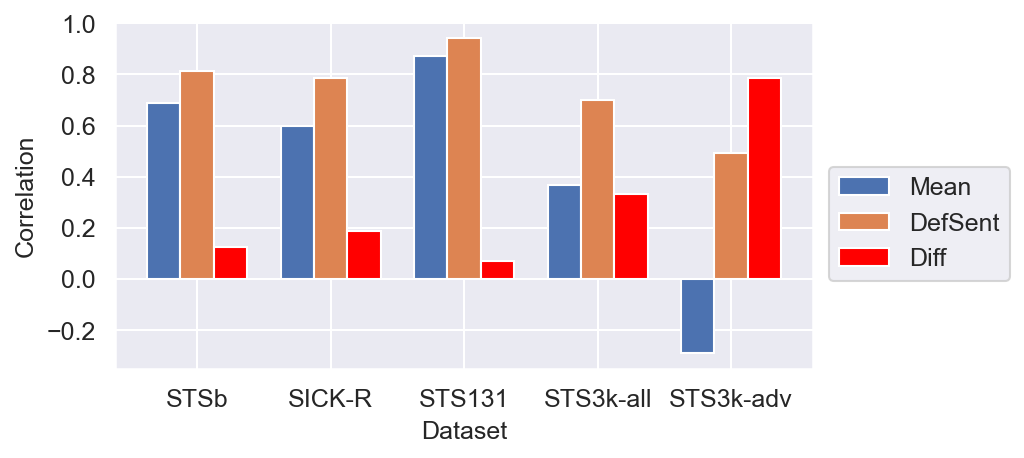

In [31]:
## Plot bar graphs with correlations and differences

# Correlation set to analyse
corr_analyse = corr_storage[:,2:]
names_analyse = datasets_shortnames[2:]

# Plot parameters
x_axis = np.arange(len(corr_analyse[0]))
offsets = 1/2
bar_width = 0.25
font_size = 12

# Generate bar plot
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
plt.bar(x=x_axis-offsets*2*bar_width, height=corr_analyse[0], width=bar_width, label='Mean')
plt.bar(x=x_axis, height=corr_analyse[9], width=bar_width, label='DefSent')
plt.bar(x=x_axis+offsets*2*bar_width, height=corr_analyse[9]-corr_analyse[0], width=bar_width, label='Diff', color='red')
plt.xticks(x_axis, names_analyse, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size, bbox_to_anchor=(1.3, 0.62), loc='upper right')
plt.ylabel('Correlation', fontsize=font_size)
plt.xlabel('Dataset', fontsize=font_size)
plt.show()

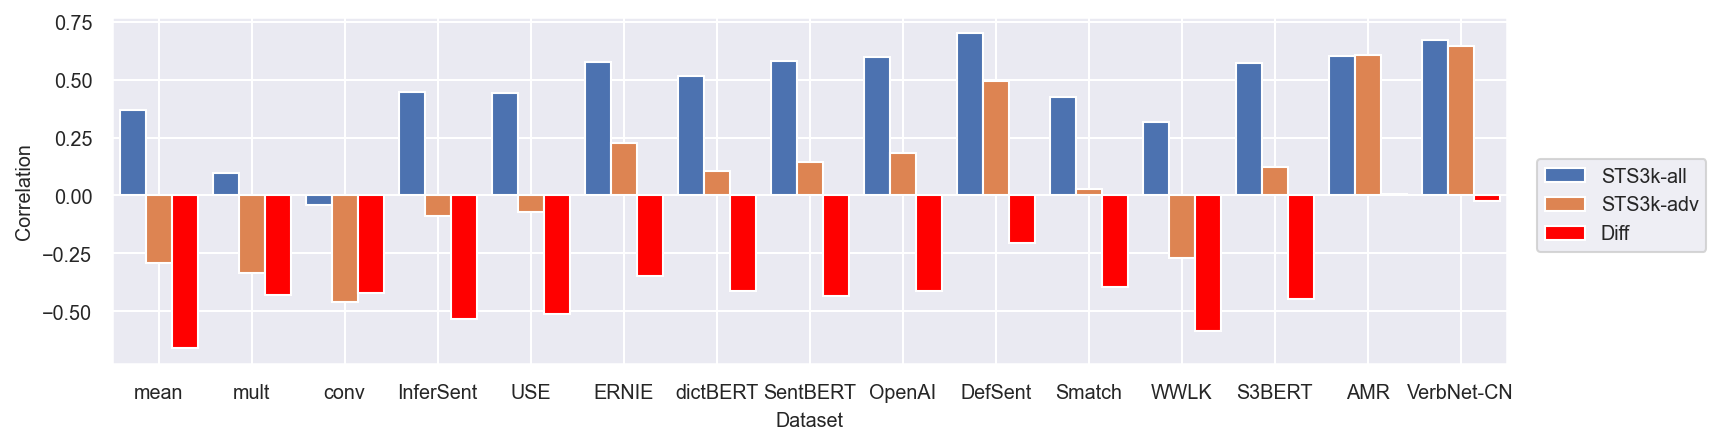

In [33]:
## Plot bar graphs with correlations and differences

# Correlation set to analyse
corr_analyse = corr_storage
names_analyse = models_shortnames

# Plot parameters
x_axis = np.arange(len(corr_analyse[:,0]))
offsets = 1/2
bar_width = 0.28
font_size = 9.5

# Generate bar plot
fig, ax = plt.subplots(figsize=(12,3), dpi=150)
plt.bar(x=x_axis-offsets*2*bar_width, height=corr_analyse[:,5], width=bar_width, label='STS3k-all')
plt.bar(x=x_axis, height=corr_analyse[:,6], width=bar_width, label='STS3k-adv')
plt.bar(x=x_axis+offsets*2*bar_width, height=corr_analyse[:,6]-corr_analyse[:,5], width=bar_width, label='Diff', color='red')
plt.xticks(x_axis, names_analyse, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size, bbox_to_anchor=(1.15, 0.62), loc='upper right')
plt.ylabel('Correlation', fontsize=font_size)
plt.xlabel('Dataset', fontsize=font_size)
plt.xlim(xmax = 14.5, xmin = -0.5)
plt.show()